In [165]:
import numpy as np
import pandas as pd
pd.options.display.max_rows = 999
#pd.set_option('mode.chained_assignment', None)

import datetime
import gc
import time
import pickle

import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline 
import seaborn as sns
sns.set()

from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb


In [2]:
# credit https://www.kaggle.com/roydatascience/elo-stack-interactions-on-categorical-variables
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [168]:
train = reduce_mem_usage(pd.read_csv('./input/train.csv', parse_dates=["first_active_month"]))
test = reduce_mem_usage(pd.read_csv('./input/test.csv', parse_dates=["first_active_month"]))
historical_transactions = reduce_mem_usage(pd.read_csv('./input/historical_transactions.csv', parse_dates=["purchase_date"]))
new_merchant_transactions = reduce_mem_usage(pd.read_csv('./input/new_merchant_transactions.csv', parse_dates=["purchase_date"]))

Mem. usage decreased to  4.04 Mb (56.2% reduction)
Mem. usage decreased to  2.24 Mb (52.5% reduction)
Mem. usage decreased to 1749.11 Mb (43.7% reduction)
Mem. usage decreased to 114.20 Mb (45.5% reduction)


In [ ]:
with open('train.pkl', 'wb') as f:
    pickle.dump(train, f, pickle.HIGHEST_PROTOCOL)
with open('test.pkl', 'wb') as f:
    pickle.dump(test, f, pickle.HIGHEST_PROTOCOL)
with open('historical_transactions.pkl', 'wb') as f:
    pickle.dump(historical_transactions, f, pickle.HIGHEST_PROTOCOL)
with open('new_merchant_transactions.pkl', 'wb') as f:
    pickle.dump(new_merchant_transactions, f, pickle.HIGHEST_PROTOCOL)

In [125]:
with open('train.pkl', 'rb') as f:
    train = pickle.load(f)
with open('test.pkl', 'rb') as f:
    test = pickle.load(f)

In [67]:
# replace one NaN date with most frequent
test.loc[test.first_active_month.isna(), 'first_active_month'] = test.first_active_month.value_counts().idxmax()

In [ ]:
with open('historical_transactions.pkl', 'rb') as f:
    historical_transactions = pickle.load(f)
with open('new_merchant_transactions.pkl', 'rb') as f:
    new_merchant_transactions = pickle.load(f)

### Transactions

In [5]:
transactions = pd.concat([historical_transactions, new_merchant_transactions], ignore_index=True)

In [6]:
# filter transactions with card_id in training and test sets
# use copy() to avoid SettingWithCopy warning
trans_train = transactions.loc[transactions.card_id.isin(train.card_id.unique()) ].copy()
trans_test = transactions.loc[transactions.card_id.isin(test.card_id.unique()) ].copy()

In [7]:
del historical_transactions
del new_merchant_transactions
del transactions

In [4]:
def process_df(df, features):
    '''
    replaces missing values w/most frequent
    adds 'isna' indicator column
    factorizes categories
    adds date details
    '''
    # missing values processing
    most_freq = []
    for idx, feat in enumerate(features):
        isnan_feature = feat + '_isnan'
        df[isnan_feature] = 0
        df.loc[df[feat].isna(), isnan_feature] = 1    
        most_freq.append(df[feat].value_counts().idxmax())
        df.loc[df[feat].isna(), feat] = most_freq[idx]       
        
    # factorize categories
    df.authorized_flag = pd.factorize(df.authorized_flag)[0]
    df.category_1 = pd.factorize(df.category_1)[0]
    df.category_3 = pd.factorize(df.category_3)[0] # 4 categories if NaN
    
    # date details
    df['month'] = df.purchase_date.dt.month
    df['year'] = df.purchase_date.dt.year
    df['day'] = df.purchase_date.dt.day
    df['day_of_year'] = df.purchase_date.dt.dayofyear
    df['day_of_week'] = df.purchase_date.dt.dayofweek
    df['is_month_start'] = df.purchase_date.dt.is_month_start.astype(int)
    df['is_month_end'] = df.purchase_date.dt.is_month_end.astype(int)
    df['is_weekend'] = (df.purchase_date.dt.dayofweek >= 5).astype(int)
    df['is_weekday'] = (df.purchase_date.dt.dayofweek < 5).astype(int)
    df['weekday'] = df.purchase_date.dt.weekday
    df['week_of_year'] = df.purchase_date.dt.weekofyear
    df['days_since_purchase'] = (datetime.datetime.today() - df.purchase_date).dt.days
    df['quarter'] = df.purchase_date.dt.quarter
    df['hour'] = df.purchase_date.dt.hour
    df['months_since_purchase'] = ((datetime.datetime.today() - df.purchase_date)/np.timedelta64(1, 'M')).astype(int)
    
    # interaction
    df['duration'] = df['purchase_amount'] * df['months_since_purchase']

In [5]:
process_df(trans_train, ['category_3', 'merchant_id', 'category_2'])
process_df(trans_test, ['category_3', 'merchant_id', 'category_2'])

In [5]:
with open('trans_train.pkl', 'rb') as f:
    trans_train = pickle.load(f)
with open('trans_test.pkl', 'rb') as f:
    trans_test = pickle.load(f)

### Aggregate card_id data from transactions

#### desc. statistics

In [12]:
agg_dict = {
    'card_id' : ['size'],
    'purchase_date' : ['min', 'max'],
    'city_id' : ['nunique', ], # num. of cities
    'installments' : ['mean', 'max', 'min', 'sum', 'std'],
    'merchant_category_id' : ['nunique', ], 
    'month_lag' : ['mean', 'max', 'min', 'sum', 'std'],
    'purchase_amount' : ['mean', 'max', 'min', 'sum', 'std'], 
    'category_2': ['nunique', ],
    'state_id' : ['nunique', ],
    'subsector_id' : ['nunique', ], 
    'merchant_id_isnan' : ['sum'], 
    'category_3_isnan': ['sum'], 
    'category_2_isnan': ['sum'],
    'authorized_flag': ['sum'],
    'category_1' : ['nunique', ],
    'category_3': ['nunique', ],
    'month': ['mean', 'max', 'min',  ], 
    'year': ['mean', 'max', 'min',   ], 
    'day': ['mean', 'max', 'min',   ], 
    'weekday': ['mean', 'max', 'min', ], 
    'week_of_year': ['mean', 'max', 'min',  ],
    'day_of_year': ['mean', 'max', 'min', ],
    'day_of_week': ['mean', 'max', 'min',  ],
    'months_since_purchase' : ['mean', 'max', 'min',  'sum'],
    'quarter' : ['mean', 'max', 'min', ],
    'hour' : ['mean', 'max', 'min', ],
    'is_month_start': ['sum'],
    'is_month_end': ['sum'],
    'is_weekend': ['sum'],
    'is_weekday': ['sum'],
    'duration' : ['mean', 'max', 'min',  'sum']
}

In [100]:
%%time 
gb = trans_train.drop(columns=['merchant_id']).groupby('card_id') \
    .agg(agg_dict, as_index=False) \
    .reset_index()

gb.columns = [val[0] if val[-1]=='' else '_'.join(val) for val in gb.columns.values] # deal w/ multiindex

/home/gael/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:1351: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var(ddof=ddof, **kwargs))


CPU times: user 38.9 s, sys: 22 s, total: 1min
Wall time: 2min 8s


In [103]:
%%time 
gb_test = trans_test.drop(columns=['merchant_id']).groupby('card_id') \
    .agg(agg_dict, as_index=False) \
    .reset_index()

gb_test.columns = [val[0] if val[-1]=='' else '_'.join(val) for val in gb_test.columns.values] # deal w/ multiindex

/home/gael/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:1351: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var(ddof=ddof, **kwargs))


CPU times: user 22 s, sys: 11 s, total: 33.1 s
Wall time: 59.1 s


#### most frequent

In [106]:
most_frequent = lambda x:x.value_counts().index[0]
agg_dict_most_freq = {
    'city_id' : most_frequent, # num. of cities, most frequent
    'merchant_id' : most_frequent, 
    'merchant_category_id' : most_frequent, 
    'category_2': most_frequent,
    'state_id' : most_frequent,
    'subsector_id' : most_frequent, 
   'category_1' : most_frequent,
    'category_3': most_frequent,   
}

In [107]:
%%time 
gb_most_freq = trans_train.groupby('card_id') \
    .agg(agg_dict_most_freq, as_index=False) \
    .reset_index()

gb_most_freq.columns = ['card_id'] + gb_most_freq.drop(columns='card_id')\
                                                .rename(columns=lambda x: x+'_most_freq').columns.tolist()

CPU times: user 11min 8s, sys: 3.55 s, total: 11min 12s
Wall time: 11min 21s


In [111]:
%%time 
gb_most_freq_test = trans_test.groupby('card_id') \
    .agg(agg_dict_most_freq, as_index=False) \
    .reset_index()

gb_most_freq_test.columns = ['card_id'] + gb_most_freq_test.drop(columns='card_id')\
                                                        .rename(columns=lambda x: x+'_most_freq').columns.tolist()

CPU times: user 6min 41s, sys: 2.22 s, total: 6min 43s
Wall time: 6min 49s


#### frequence value of most frequent keys

In [114]:
freq = lambda x:x.value_counts().values[0]
agg_dict_freq = {
     'city_id' : freq, # num. of cities, most frequent
    'merchant_id' : freq, 
    'merchant_category_id' : freq, 
    'category_2': freq,
    'state_id' : freq,
    'subsector_id' : freq, 
   'category_1' : freq,
    'category_3': freq,   
}

In [115]:
%%time 
gb_freq = trans_train.groupby('card_id') \
    .agg(agg_dict_freq, as_index=False) \
    .reset_index()

gb_freq.columns = ['card_id'] + gb_freq.drop(columns='card_id')\
                                    .rename(columns=lambda x: x+'_freq').columns.tolist()

CPU times: user 11min 7s, sys: 1.82 s, total: 11min 9s
Wall time: 11min 9s


In [118]:
%%time 
gb_freq_test = trans_test.groupby('card_id') \
    .agg(agg_dict_freq, as_index=False) \
    .reset_index()

gb_freq_test.columns = ['card_id'] + gb_freq_test.drop(columns='card_id')\
                                                .rename(columns=lambda x: x+'_freq').columns.tolist()

CPU times: user 6min 54s, sys: 1.33 s, total: 6min 56s
Wall time: 6min 55s


### Merge aggregated transaction data with train&test sets

In [127]:
with open('gb.pkl', 'rb') as f:
    gb = pickle.load(f)
with open('gb_test.pkl', 'rb') as f:
    gb_test = pickle.load(f)
with open('gb_most_freq.pkl', 'rb') as f:
    gb_most_freq = pickle.load(f)
with open('gb_most_freq_test.pkl', 'rb') as f:
    gb_most_freq_test = pickle.load(f)
with open('gb_freq.pkl', 'rb') as f:
    gb_freq = pickle.load(f)
with open('gb_freq_test.pkl', 'rb') as f:
    gb_freq_test = pickle.load(f)

In [128]:
train = pd.merge(train, gb, on='card_id', how='left')
train = pd.merge(train, gb_most_freq, on='card_id',how='left')
train = pd.merge(train, gb_freq, on='card_id', how='left')

test = pd.merge(test, gb_test, on='card_id', how='left')
test = pd.merge(test, gb_most_freq_test, on ='card_id', how='left')
test = pd.merge(test, gb_freq_test, on='card_id', how='left')

In [130]:
del gb
del gb_freq
del gb_freq_test
del gb_most_freq
del gb_most_freq_test
gc.collect()

607

Add lag data

In [132]:
train['days_since_purchase'] = (train.purchase_date_max - train.purchase_date_min).dt.days
test['days_since_purchase'] = (test.purchase_date_max - train.purchase_date_min).dt.days

train['days_since_active'] = (datetime.datetime.today() - train.first_active_month).dt.days
test['days_since_active'] = (datetime.datetime.today() - test.first_active_month).dt.days

train['ave_purch_per_day'] = train.days_since_purchase / train.card_id_size
test['ave_purch_per_day'] = test.days_since_purchase / test.card_id_size

train['days_before_purchase'] = (train.purchase_date_min - train.first_active_month).dt.days
test['days_before_purchase'] = (test.purchase_date_min - test.first_active_month).dt.days

### Fit model (lightgbm 5-fold)

In [158]:
train["year"] = train["first_active_month"].dt.year
test["year"] = test["first_active_month"].dt.year
train["month"] = train["first_active_month"].dt.month
test["month"] = test["first_active_month"].dt.month

cols_to_use = [#'first_active_month',
 #'card_id',
 'feature_1',
 'feature_2',
 'feature_3',
 #'target',
 'card_id_size',
 #'purchase_date_min',
 #'purchase_date_max',
 'city_id_nunique',
 'installments_mean',
 'installments_max',
 'installments_min',
 'installments_sum',
 'installments_std',
 'merchant_category_id_nunique',
 'month_lag_mean',
 'month_lag_max',
 'month_lag_min',
 'month_lag_sum',
 'month_lag_std',
 'purchase_amount_mean',
 'purchase_amount_max',
 'purchase_amount_min',
 'purchase_amount_sum',
 'purchase_amount_std',
 'category_2_nunique',
 'state_id_nunique',
 'subsector_id_nunique',
 'merchant_id_isnan_sum',
 'category_3_isnan_sum',
 'category_2_isnan_sum',
 'authorized_flag_sum',
 'category_1_nunique',
 'category_3_nunique',
 'month_mean',
 'month_max',
 'month_min',
 'year_mean',
 'year_max',
 'year_min',
 'day_mean',
 'day_max',
 'day_min',
 'weekday_mean',
 'weekday_max',
 'weekday_min',
 'week_of_year_mean',
 'week_of_year_max',
 'week_of_year_min',
 'day_of_year_mean',
 'day_of_year_max',
 'day_of_year_min',
 'day_of_week_mean',
 'day_of_week_max',
 'day_of_week_min',
 'months_since_purchase_mean',
 'months_since_purchase_max',
 'months_since_purchase_min',
 'months_since_purchase_sum',
 'quarter_mean',
 'quarter_max',
 'quarter_min',
 'hour_mean',
 'hour_max',
 'hour_min',
 'is_month_start_sum',
 'is_month_end_sum',
 'is_weekend_sum',
 'is_weekday_sum',
 'duration_mean',
 'duration_max',
 'duration_min',
 'duration_sum',
 'city_id_most_freq',
 #'merchant_id_most_freq',
 'merchant_category_id_most_freq',
 'category_2_most_freq',
 'state_id_most_freq',
 'subsector_id_most_freq',
 'category_1_most_freq',
 'category_3_most_freq',
 'city_id_freq',
 'merchant_id_freq',
 'merchant_category_id_freq',
 'category_2_freq',
 'state_id_freq',
 'subsector_id_freq',
 'category_1_freq',
 'category_3_freq',
 'days_since_purchase',
 'days_since_active',
 'ave_purch_per_day',
 'days_before_purchase',
 'year',
 'month'
              ]

In [159]:
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse",
        "num_leaves" : 30,
        "min_child_weight" : 50,
        "learning_rate" : 0.05,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.7,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    evals_result = {}
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100, evals_result=evals_result)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    return pred_test_y, model, evals_result

train_X = train[cols_to_use]
test_X = test[cols_to_use]
train_y = train['target'].values

pred_test = 0
val_rmse_tmp = 0
kf = model_selection.KFold(n_splits=5, random_state=2018, shuffle=True)
for dev_index, val_index in kf.split(train):
    dev_X, val_X = train_X.loc[dev_index,:], train_X.loc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]
    
    pred_test_tmp, model, evals_result = run_lgb(dev_X, dev_y, val_X, val_y, test_X)
    pred_test += pred_test_tmp
    
    val_rmse_tmp += min(evals_result['valid_0']['rmse'])

pred_test /= 5.
val_rmse_tmp /= 5.
print('val_rmse : ', val_rmse_tmp)

Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.72911
[200]	valid_0's rmse: 3.72734
Early stopping, best iteration is:
[178]	valid_0's rmse: 3.72675
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.68641
[200]	valid_0's rmse: 3.68396
Early stopping, best iteration is:
[193]	valid_0's rmse: 3.68335
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.70539
[200]	valid_0's rmse: 3.70174
[300]	valid_0's rmse: 3.70181
Early stopping, best iteration is:
[213]	valid_0's rmse: 3.70133
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.69878
[200]	valid_0's rmse: 3.69466
Early stopping, best iteration is:
[190]	valid_0's rmse: 3.69424
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's rmse: 3.76988
[200]	valid_0's rmse: 3.76525
[300]	valid_0's rmse: 3.76464
[400]	valid_0's rmse: 3.76439
Early stopping, best iteration is:


In [ ]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(train_predictions, y))

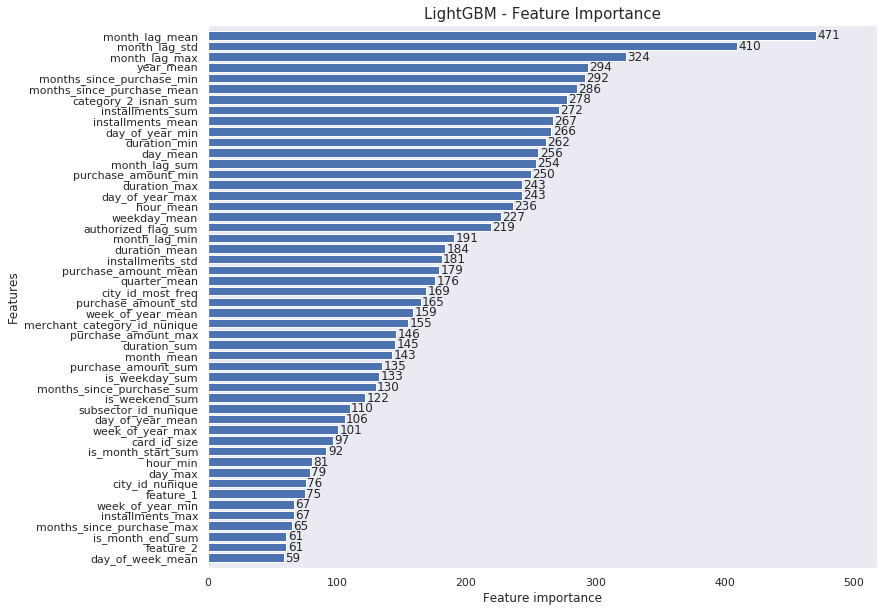

In [166]:
fig, ax = plt.subplots(figsize=(12,10))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()

In [167]:
subm_df = pd.DataFrame({"card_id":test["card_id"].values})
subm_df["target"] = pred_test
subm_df.to_csv("ELO_V11.csv", index=False)